# visualize surprisal development


In [15]:
import ast
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression

ROOT = Path("/Users/jliu/workspace/RAG/")
fig_path = ROOT / "fig"
surprisal_path = ROOT / "results" / "surprisal"
KL_path = ROOT / "results" / "token_freq"
freq_path = ROOT / "datasets/freq/EleutherAI/pythia-410m"

# Set at the beginning of your script
pd.options.mode.chained_assignment = None  # 'warn' is default, None suppresses

neuron_colors = {
        0: "#1f77b4",    # blue for baseline
        10: "#ff7f0e",   # orange
        50: "#2ca02c",   # green
        500: "#9467bd"   # purple
    }

## KL difference

In [83]:

def d_stats(x):
    """Descriptive stats for an array of values."""
    stats = {
        "mean": np.mean(x),
        "median": np.median(x),
        "min": np.min(x),
        "max": np.max(x),
        "stdev": np.std(x, ddof=1),
        "first": np.percentile(x, 25),
        "third": np.percentile(x, 75),
    }
    return stats

def load_kl(file_path: Path) -> list[float]:
    """Load the kl_diff column from a CSV file and convert it to a flat list of floats."""
    df = pd.read_csv(file_path)
    kl_diff_strings = df["kl_diff"].tolist()
    # Convert each string representation of a list to an actual list
    kl_diff_lists = [ast.literal_eval(kl_diff_str) for kl_diff_str in kl_diff_strings]
    # Flatten the list of lists into a single list of floats
    flat_kl_diff = [float(val) for sublist in kl_diff_lists for val in sublist]
    # get the stats o fthe given list
    kl_stat = d_stats(flat_kl_diff)
    stat_df = pd.DataFrame(kl_stat, index=[0])
    return flat_kl_diff,stat_df


In [84]:
# plot KL difference in differnt conditions
effect_lst=["boost","supress"]
vec_lst = ["mean","longtail"]
model_lst = ["70m","410m"]
neuron_lst = [10,50,500]

stat_frame = pd.DataFrame()
for vec in vec_lst:
    for model in model_lst:
        suffix_path = Path(vec)/"EleutherAI"/f"pythia-{model}-deduped"
        data_dict = {}
        for neuron in neuron_lst:
            data_dict[neuron] = {}
            for effect in effect_lst:
                # load file
                file_path = KL_path / effect / suffix_path / f"500_{neuron}.csv"
                kl_lst,stat_df = load_kl(file_path)
                data_dict[neuron][effect] = kl_lst
                header_dict = {"vec":vec,"model":model,"neuron":neuron,"effect":effect}
                for header,col in header_dict.items():
                    stat_df[header]=col
                stat_frame = pd.concat([stat_frame,stat_df])

        # plot distribution





In [86]:
stat_frame.to_csv(KL_path / "kl_diff_stat.csv")

In [82]:
pd.DataFrame(kl_stat, index=[0])

mean    median       min       max     stdev     first     third
0  0.00003  0.000027  0.000002  0.002275  0.000025  0.000018  0.000036

In [57]:
import seaborn as sns
from matplotlib.colors import to_rgba

def plot_kl_distributions(
    data_dict: dict[str, dict[str, dict[int, dict[str, list[float]]]]],
    neuron_colors: dict[int, str],
    vec_type: str,
    model_type: str,
    output_dir: Path
) -> None:
    """
    Plot KL difference distributions for different neuron counts and effects.
    
    Args:
        data_dict: Nested dictionary containing the KL data
        neuron_colors: Dictionary mapping neuron counts to colors
        vec_type: Vector type to plot ('mean' or 'longtail')
        model_type: Model type to plot ('70m' or '410m')
        output_dir: Directory to save the output plots
    """
    # Create output directory if it doesn't exist
    output_dir = Path(output_dir) if isinstance(output_dir, str) else output_dir
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Define effect transparency levels
    effect_alpha = {
        "boost": 0.8,  # Heavy shade for boost
        "supress": 0.4  # Light shade for suppress
    }
    
    # Store for legend handles
    handles = []
    labels = []
    
    
    # Plot each neuron and effect combination
    for neuron, neuron_data in data_dict.items():
        if neuron not in neuron_colors:
            print(f"No color defined for neuron count {neuron}, skipping")
            continue
        
        base_color = neuron_colors[neuron]
        
        for effect, kl_values in neuron_data.items():
            if not kl_values:
                print(f"No values for neuron {neuron}, effect {effect}")
                continue
            
            # Modify alpha for effect type
            color_with_alpha = to_rgba(base_color, alpha=effect_alpha[effect])
            
            # Plot the histogram with a KDE on top
            sns.histplot(
                kl_values,
                kde=True,
                stat="density",
                color=color_with_alpha,
                alpha=effect_alpha[effect],
                label=f"{neuron} neurons ({effect})",
                # Reduce histogram opacity to make KDE more visible
                linewidth=0,
                element="step"
            )
        
        # Add neuron count to legend only once (not for each effect)
        handles.append(plt.Rectangle((0,0), 1, 1, color=base_color))
        labels.append(f"{neuron} neurons")
    
    # Set title and labels
    plt.title(f"KL Difference Distribution - {vec_type} Vector, {model_type} Model")
    plt.xlabel("KL Difference")
    plt.ylabel("Density")
    
    # Create custom legend
    plt.legend(handles, labels, title="Neuron Count")
    
    # Add text explaining shading
    plt.annotate("Note: Darker shade = boost, Lighter shade = suppress", 
                 xy=(0.02, 0.02), xycoords="figure fraction", 
                 fontsize=9, alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    

def plot_all_combinations(
    data_dict: dict[str, dict[str, dict[int, dict[str, list[float]]]]],
    output_dir: Path 
) -> None:
    """
    Generate plots for all vector and model combinations.
    
    Args:
        data_dict: Nested dictionary containing the KL data
        output_dir: Directory to save the output plots
    """
    # Define color scheme
    neuron_colors = {
        0: "#1f77b4",   # blue for baseline
        10: "#ff7f0e",  # orange
        50: "#2ca02c",  # green
        500: '#9467bd'  # purple
    }
    
    # Plot all combinations
    for vec_type in data_dict.keys():
        for model_type in data_dict[vec_type].keys():
            plot_kl_distributions(
                data_dict, 
                neuron_colors, 
                vec_type, 
                model_type, 
                output_dir
            )

    
    
    print(f"All plots saved to {output_dir}")


In [69]:
base_color

'#9467bd'

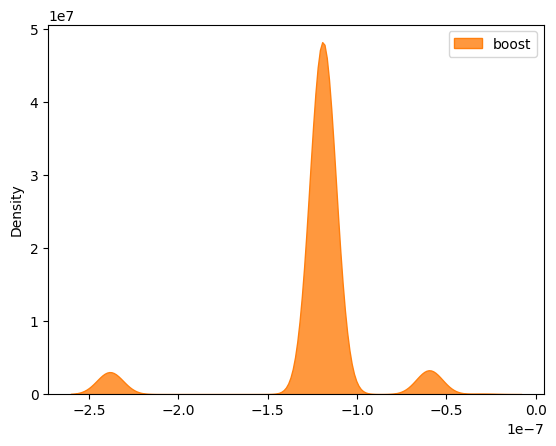

In [74]:

 # Define effect transparency levels
effect_alpha = {"boost": 0.8,  "supress": 0.4}
#for neuron, neuron_data in data_dict.items():
neuron=10
effect="boost"
base_color = neuron_colors[neuron]

#for effect, kl_values in neuron_data.items():
    # Plot the histogram with a KDE on top
kl_values = data_dict[neuron][effect]
sns.kdeplot(
    data=kl_values,
    color=base_color,
    label=effect,
    fill=True,
    alpha=effect_alpha[effect],
)
plt.legend()


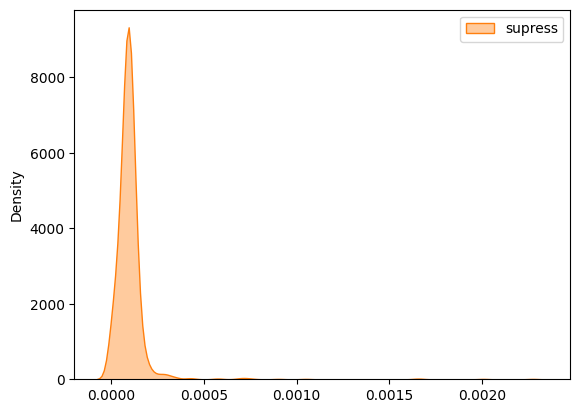

In [75]:

 # Define effect transparency levels
effect_alpha = {"boost": 0.8,  "supress": 0.4}
#for neuron, neuron_data in data_dict.items():
neuron=10
effect="supress"
base_color = neuron_colors[neuron]

#for effect, kl_values in neuron_data.items():
    # Plot the histogram with a KDE on top
kl_values = data_dict[neuron][effect]
sns.kdeplot(
    data=kl_values,
    color=base_color,
    label=effect,
    fill=True,
    alpha=effect_alpha[effect],
)
plt.legend()


## Surprisal development

In [19]:

# Set up colors for different neuron counts - matching example image
neuron_colors = {
        0: "#1f77b4",    # blue for baseline
        10: "#ff7f0e",   # orange
        50: "#2ca02c",   # green
        500: "#9467bd"   # purple
    }


ylim_dict = {
    "merged":{"70m":[11.5,15.5],"410m":[12.5,14]},
    "longtail_words":{"70m":[13,17],"410m":[13,15.5]}
    }



def plot_all(csv_path: Path, output_dir: Path,eval_set,neuron_colors=neuron_colors,ylim_dict=ylim_dict) -> None:
    """Plot the overall development"""
    # Load the data
    df = pd.read_csv(csv_path)
    print(f"Loaded data with {len(df)} rows")
    # Get unique values for grouping
    models = df["model"].unique()
    effect_lst = df["effect"].unique()
    vec_lst = ["mean","longtail"]
    ablations = [a for a in df["ablation"].unique() if a != "base"]  # Non-baseline ablations
    neurons = sorted([n for n in df["neuron"].unique()])
    # Identify numeric columns (metrics)
    metrics = ["surprisal"]

    # Process each model and ablation type
    for effect in effect_lst:
        for vec in vec_lst:
            for model in models:
                for ablation in ablations:

                    print(f"Processing eval={eval_set}, vec={vec}, model={model}, ablation={ablation}")
                    # Create a new figure
                    plt.figure(figsize=(10, 8))

                    # Filter data for this model
                    model_data = df[(df["model"] == model)&(df["vec"] == vec)&(df["eval"] == eval_set)
                                    &(df["effect"] == effect)]
                    # Get baseline data (always include baseline for comparison)
                    baseline_data = df[(df["model"] == model)&(df["ablation"] == "base")
                                    &(df["eval"] == eval_set)&(df["effect"] == effect)]
                    # For each log_step, calculate mean across all metrics
                    baseline_grouped = baseline_data.groupby("log_step")
                    x_values = sorted(baseline_data["log_step"].unique())
                    y_values = []

                    for log_step in x_values:
                        step_data = baseline_grouped.get_group(log_step)
                        mean_val = step_data[metrics].values.mean()
                        y_values.append(mean_val)
                    # Plot baseline
                    plt.plot(x_values, y_values, color=neuron_colors[0], linewidth=2, label="base")
                    # Process each neuron condition for this ablation
                    for neuron in neurons:
                        if neuron == 0:  # Skip 0 neuron as it's part of baseline
                            continue

                        # Filter data for this neuron and ablation combination
                        condition_data = model_data[(model_data["neuron"] == neuron) &
                                                (model_data["ablation"] == ablation)]

                        if condition_data.empty:
                            continue

                        # For each log_step, calculate mean across all metrics
                        condition_grouped = condition_data.groupby("log_step")
                        x_values = sorted(condition_data["log_step"].unique())
                        y_values = []

                        for log_step in x_values:
                            if log_step in condition_grouped.groups:
                                step_data = condition_grouped.get_group(log_step)
                                mean_val = step_data[metrics].values.mean()
                                y_values.append(mean_val)
                            else:
                                # Handle missing log_step values
                                y_values.append(np.nan)

                        # Plot this neuron condition
                        plt.plot(x_values, y_values, color=neuron_colors.get(neuron, "gray"),
                                linewidth=2, label=str(neuron))

                    # Style the plot to match the example
                    plt.xlabel("Log step", fontsize=11)
                    plt.ylabel("Mean surprisal", fontsize=11)
                    plt.title(f"model={model}, intervention={ablation}", fontsize=13)
                    plt.grid(alpha=0.2)

                    # Create legend to match example
                    handles, labels = plt.gca().get_legend_handles_labels()

                    # If baseline is in the legend, make sure it comes first
                    if "base" in labels:
                        base_idx = labels.index("base")
                        # Move baseline to front
                        handles = [handles[base_idx]] + [h for i, h in enumerate(handles) if i != base_idx]
                        labels = [labels[base_idx]] + [l for i, l in enumerate(labels) if i != base_idx]

                    plt.legend(handles, labels, loc="lower left")
                    plt.ylim(ylim_dict[eval_set][model])
                    # Save the figure
                    plt.tight_layout()

                    # Create output directory if it doesn't exist
                    (output_dir/effect).mkdir(parents=True, exist_ok=True)
                    plt.savefig(output_dir/effect / f"{vec}_{model}_{ablation}.png", dpi=300, bbox_inches="tight")
                    plt.close()


In [20]:
eval_set="merged"
output_dir = fig_path  / "mean_dev"/ eval_set
csv_path = surprisal_path/"stat_all.csv"
# Create bar plots
plot_all(csv_path = csv_path, output_dir=output_dir,eval_set=eval_set)


eval_set="longtail_words"
output_dir = fig_path  / "mean_dev"/ eval_set
# Create bar plots
plot_all(csv_path = csv_path, output_dir=output_dir,eval_set=eval_set)


Loaded data with 15120 rows
Processing eval=merged, vec=mean, model=70m, ablation=mean
Processing eval=merged, vec=mean, model=70m, ablation=zero
Processing eval=merged, vec=mean, model=70m, ablation=random
Processing eval=merged, vec=mean, model=70m, ablation=scaled
Processing eval=merged, vec=mean, model=410m, ablation=mean
Processing eval=merged, vec=mean, model=410m, ablation=zero
Processing eval=merged, vec=mean, model=410m, ablation=random
Processing eval=merged, vec=mean, model=410m, ablation=scaled
Processing eval=merged, vec=longtail, model=70m, ablation=mean
Processing eval=merged, vec=longtail, model=70m, ablation=zero
Processing eval=merged, vec=longtail, model=70m, ablation=random
Processing eval=merged, vec=longtail, model=70m, ablation=scaled
Processing eval=merged, vec=longtail, model=410m, ablation=mean
Processing eval=merged, vec=longtail, model=410m, ablation=zero
Processing eval=merged, vec=longtail, model=410m, ablation=random
Processing eval=merged, vec=longtail, 

In [99]:
file_path

PosixPath('/Users/jliu/workspace/RAG/results/surprisal/longtail/random/longtail_words/EleutherAI/pythia-410m-deduped_500.csv')

## AoA of model and human 

In [160]:
# Alternative using column position
def get_word_h(data):
    """Get the mean h across contexts."""
    group_column = "target_word"
    group_index = data.columns.get_loc(group_column)
    value_columns = data.columns[group_index + 1:]
    result = data.groupby(group_column)[value_columns].mean().reset_index()
    return result

def load_freq(freq_path:Path):
    """Get freq of each word."""
    # load the reference freq
    cdi_data = pd.read_csv(freq_path/"cdi_childes.csv")
    ox_data = pd.read_csv(freq_path/"cdi_childes.csv")
    words = set(ox_data["word"]) - set(cdi_data["word"])
    # Select the additional words
    sel_df = ox_data[ox_data["word"].isin(words)]
    # Concatenate the rows
    merged = pd.concat([cdi_data, sel_df])
    return merged


# loop over the indices
def find_median(numbers: list,log_steps:list):
    """Find the median value that exists in the list and its first occurrence index."""
    if not numbers:
        raise ValueError("Input list cannot be empty")
    # Create a sorted copy to find the median value
    sorted_nums = sorted(numbers)
    n = len(sorted_nums)
    median = sorted_nums[n // 2]
    # Find the first occurrence of the median in the original list
    first_occurrence_index = numbers.index(median)
    return median, float(log_steps[first_occurrence_index])

def predict_aoa(data,row_index):
    h_df = data.drop(columns=["target_word"])
    h_lst = h_df.iloc[row_index].tolist()
    log_steps = h_df.columns.tolist()
    median_h,log_step = find_median(h_lst,log_steps)
    return log_step


def match_result(data:pd.DataFrame,merged:pd.DataFrame):
    """Get the freq of the target."""
    aoa_lst = []
    freq_lst = []
    n = 0
    while n < data.shape[0]:
        try:
            freq = np.log10(float(merged[merged["word"]==(data["target_word"].tolist()[n])]["freq_m"].item()) + 1e-10)
        except:
            freq=0
        freq_lst.append(freq)
        aoa_lst.append(predict_aoa(data,n))
        n += 1
    data["log_step"] = aoa_lst
    data["freq"] = freq_lst
    return data


In [171]:


@dataclass
class RegressionResult:
    """Class to store linear regression results"""

    slope: float
    intercept: float
    r_squared: float
    p_value: float
    std_err: float

def fit_linear_regression(
    df: pd.DataFrame,
    x_column: str,
    y_column: str,
    plot: bool = False
) -> RegressionResult:
    """Fit a linear regression model between two columns in a DataFrame.
    
    Args:
        df: Input DataFrame
        x_column: Name of the column to use as predictor (X)
        y_column: Name of the column to use as target (y)
        plot: Whether to generate and display a scatter plot with regression line
        
    Returns:
        RegressionResult object containing regression statistics

    """
    # Check if columns exist in DataFrame
    if x_column not in df.columns:
        raise ValueError(f"Column '{x_column}' not found in DataFrame")
    if y_column not in df.columns:
        raise ValueError(f"Column '{y_column}' not found in DataFrame")

    # Extract data and remove rows with NaN values
    data = df[[x_column, y_column]].dropna()

    # Reshape data for sklearn
    X = data[x_column].values.reshape(-1, 1)
    y = data[y_column].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Calculate R-squared
    r_squared = model.score(X, y)

    # For p-value and standard error, we need scipy
    p_value = None
    std_err = None
    try:


        # Calculate prediction
        y_pred = model.predict(X)

        # Calculate residuals
        residuals = y - y_pred

        # Degrees of freedom
        n = len(X)
        k = 1  # number of predictors
        df_residuals = n - k - 1

        # Mean squared error
        mse = np.sum(residuals**2) / df_residuals

        # Standard errors
        X_mean = np.mean(X)
        se = np.sqrt(mse / np.sum((X - X_mean)**2))
        std_err = se[0] if isinstance(se, np.ndarray) else se

        # T-statistic and p-value
        t_stat = model.coef_[0] / std_err
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_residuals))

    except ImportError:
        # scipy not available, skip p-value calculation
        pass

    # Create plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        #plt.scatter(X, y, color='blue', alpha=0.5)
        plt.plot(X, model.predict(X), color="red", linewidth=2)
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.title(f"Linear Regression: {y_column} vs {x_column}")

        # Add regression equation and R² to plot
        """
        equation = f'y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}'
        
        r2_text = f'R² = {r_squared:.4f}'
        plt.annotate(equation + '\n' + r2_text, 
                     xy=(0.05, 0.95), 
                     xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        """

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Return regression results
    return RegressionResult(
        slope=model.coef_[0],
        intercept=model.intercept_,
        r_squared=r_squared,
        p_value=p_value,
        std_err=std_err
    )


In [179]:
def fit_curves(file_path,merged):

    data = load_file(file_path,0)
    # get mean surprisal by each word
    data = get_word_h(data)
    # get the result
    result = match_result(data,merged)
    fit_linear_regression(
        df=result,
        x_column="freq",
        y_column="log_step",
        plot= True
        )
    return result



In [ ]:
def get_stat_all():
    """Get stat of all the words."""
    eval_set_lst = ["merged","longtail_words"]
    ablation_lst = ["mean","zero","random"]

    model_lst = ["70m","410m"]
    neuron_lst = [10,50,500]
    vec_lst = ["mean","longtail"]

    freq_path = Path("/Users/jliu/workspace/RAG/datasets/freq/EleutherAI/pythia-410m")
    merged = load_freq(freq_path)

    # loop ablation conditions
    for eval_set in eval_set_lst:
        for model in model_lst:
            for vec in vec_lst:
                if vec == "base":
                    header_dict = {"vec":vec,"neuron":0,"model":model, "ablation":"base","eval":eval_set}
                    file_path = surprisal_path/vec/eval_set/"EleutherAI"/f"pythia-{model}-deduped.csv"
                    fit_curves(file_path,merged)
                else:
                    for ablation in ablation_lst:
                        for neuron in neuron_lst:
                            file_path = surprisal_path/vec/ablation/eval_set/"EleutherAI"/f"pythia-{model}-deduped_{neuron}.csv"
                            header_dict = {"vec":vec,"neuron":neuron,"model":model, "ablation":ablation,"eval":eval_set}
                            fit_curves(file_path,merged)


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

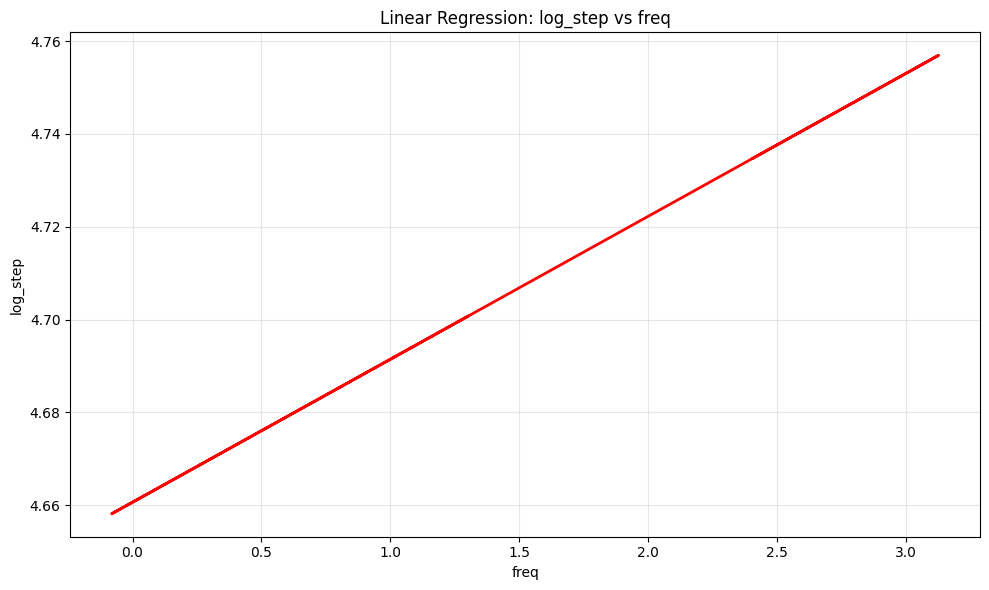

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

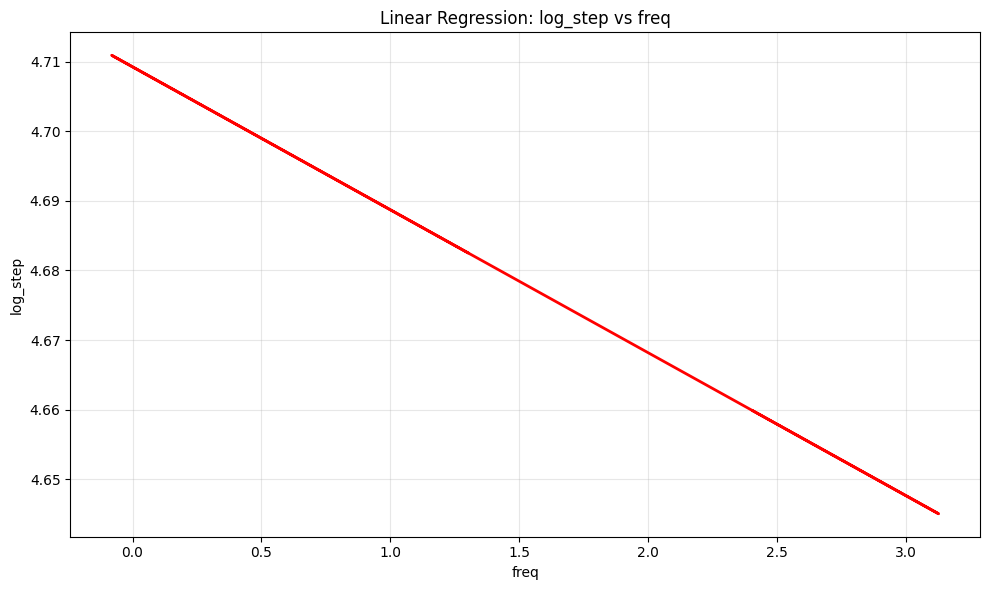

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

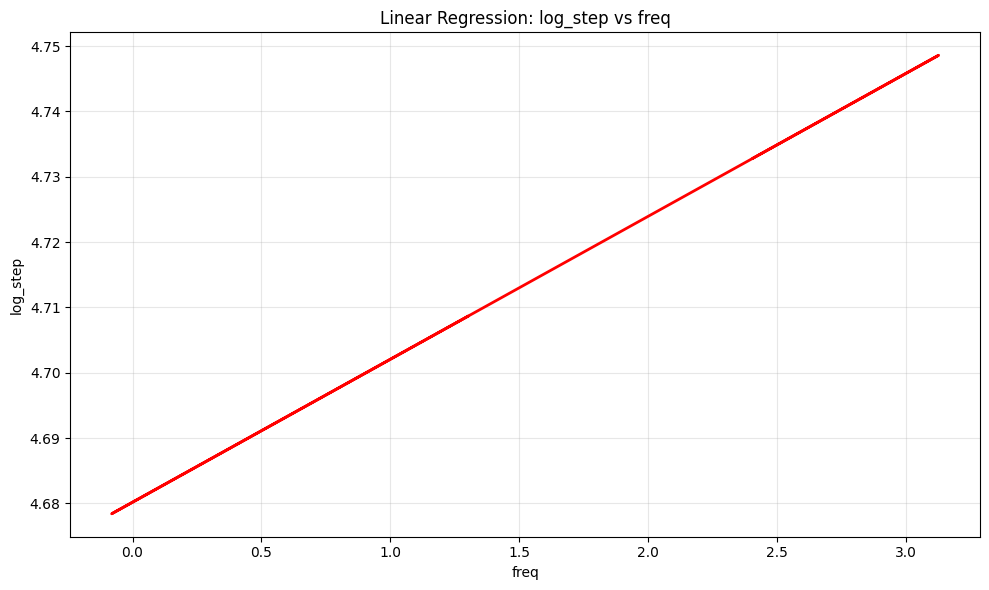

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

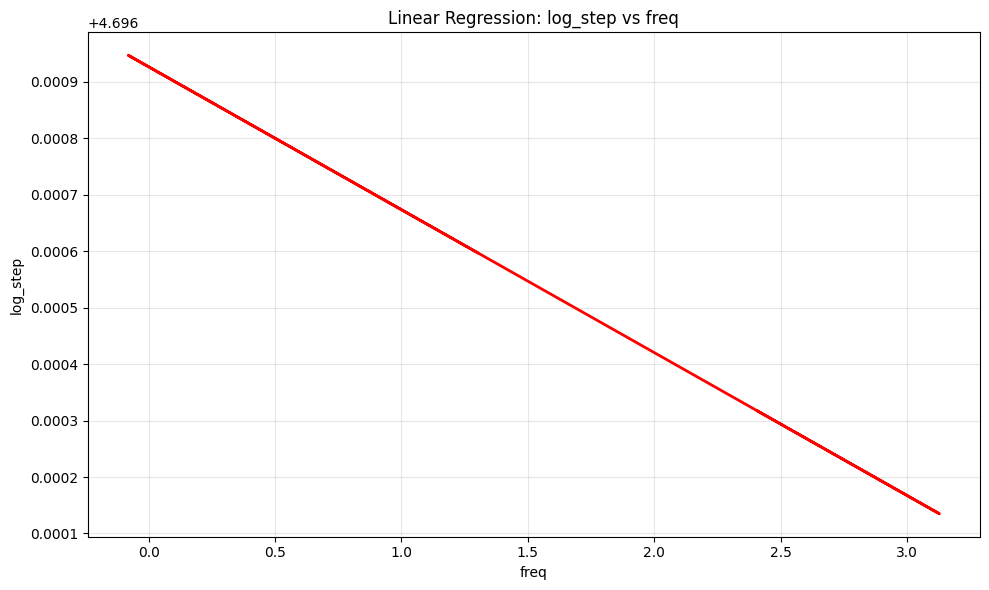

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

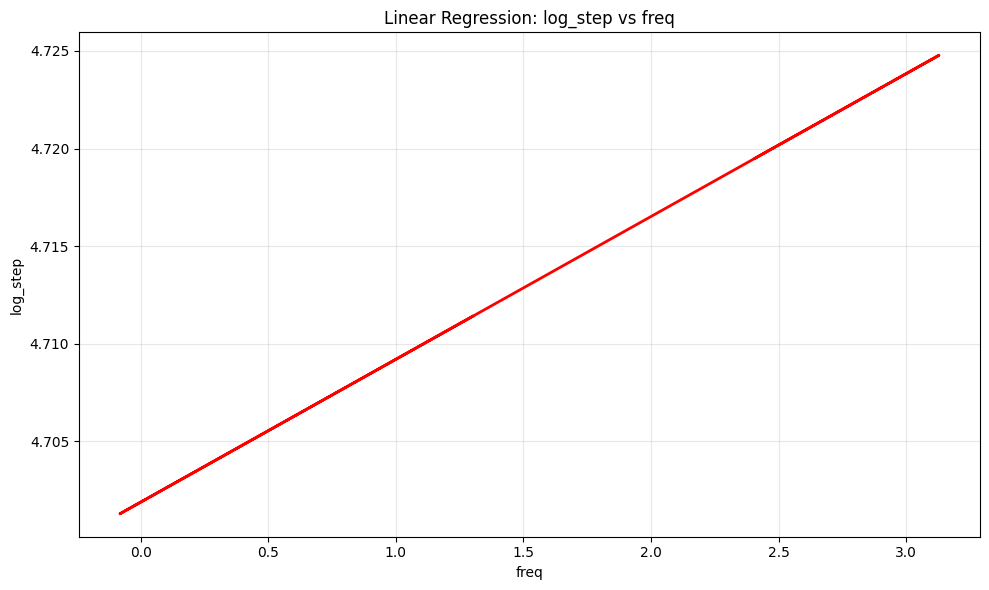

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

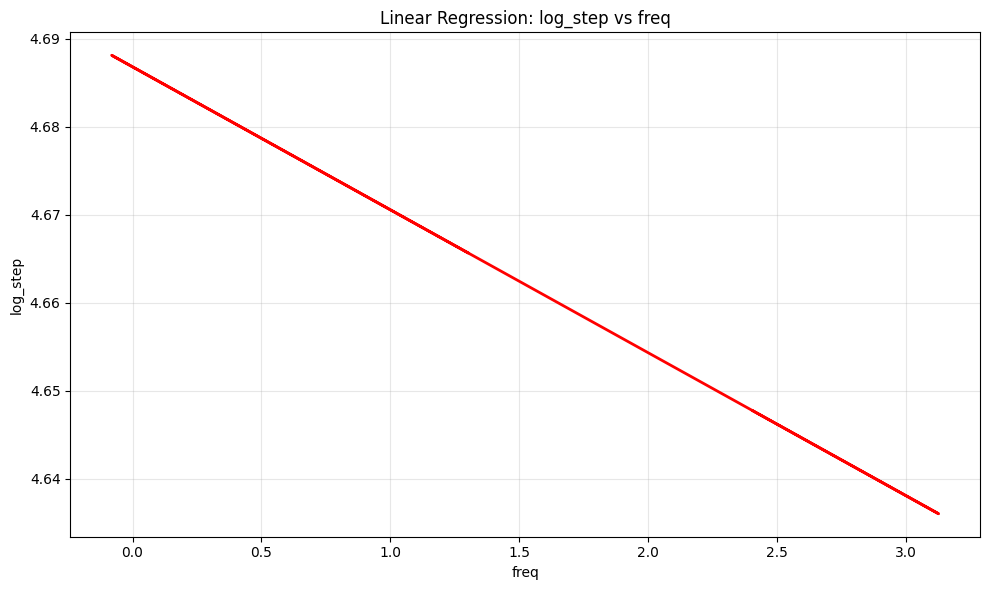

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

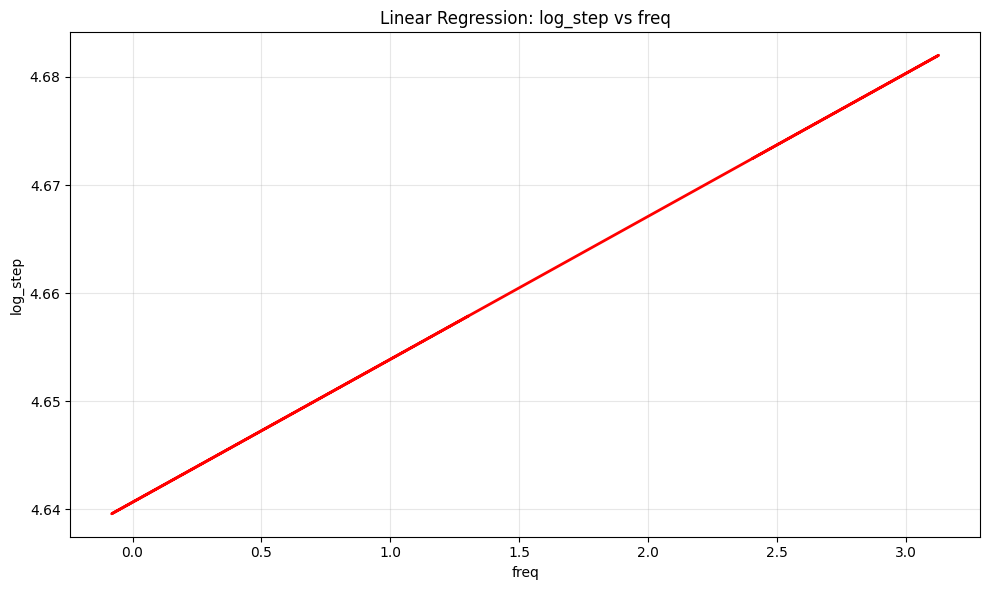

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

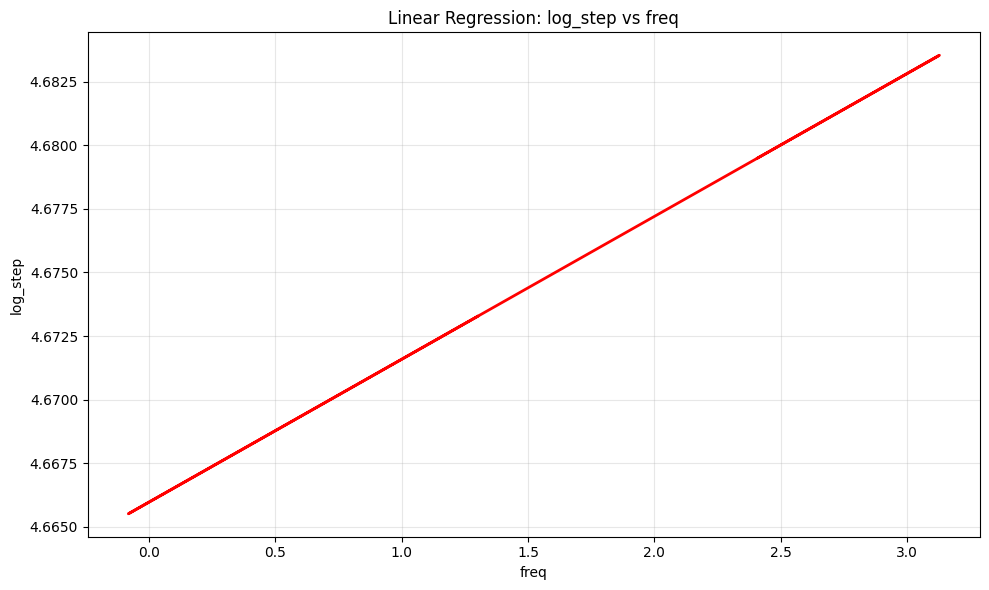

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

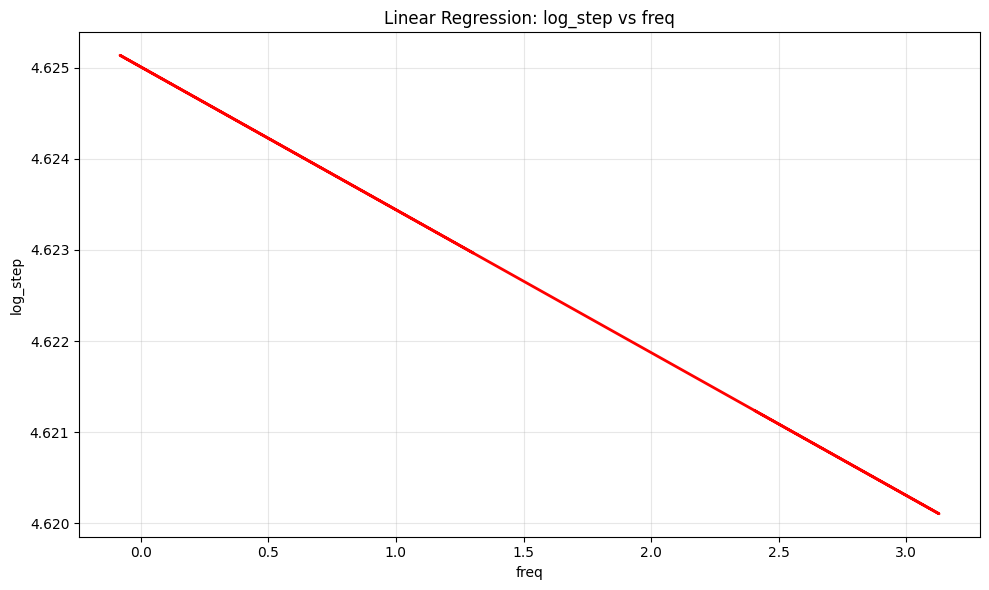

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

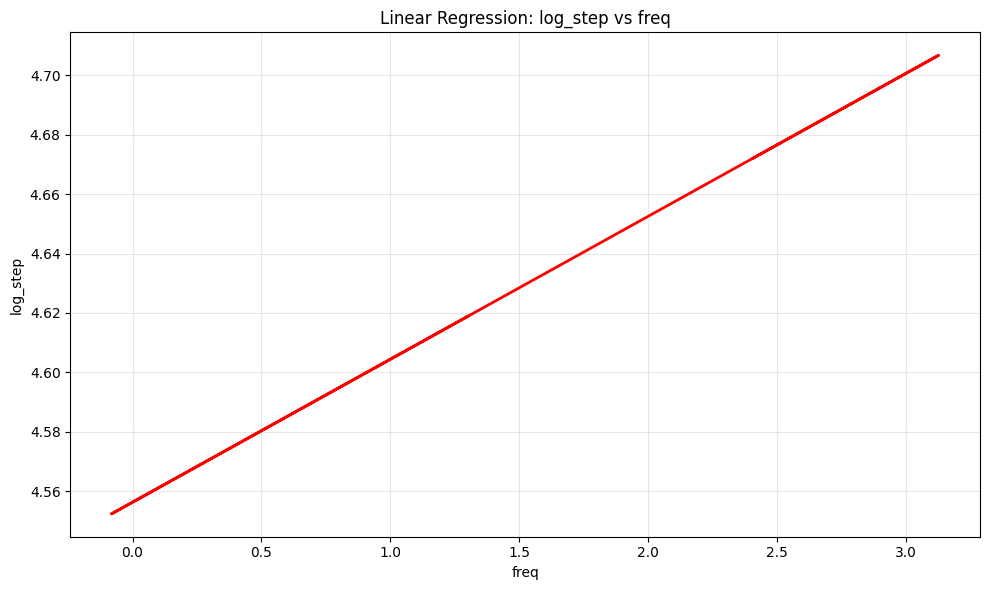

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

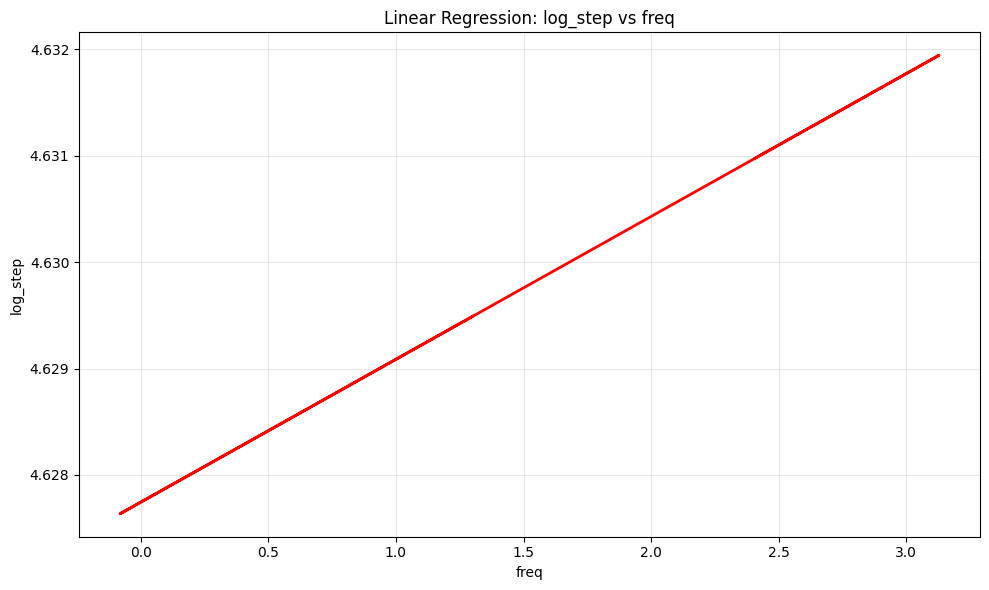

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

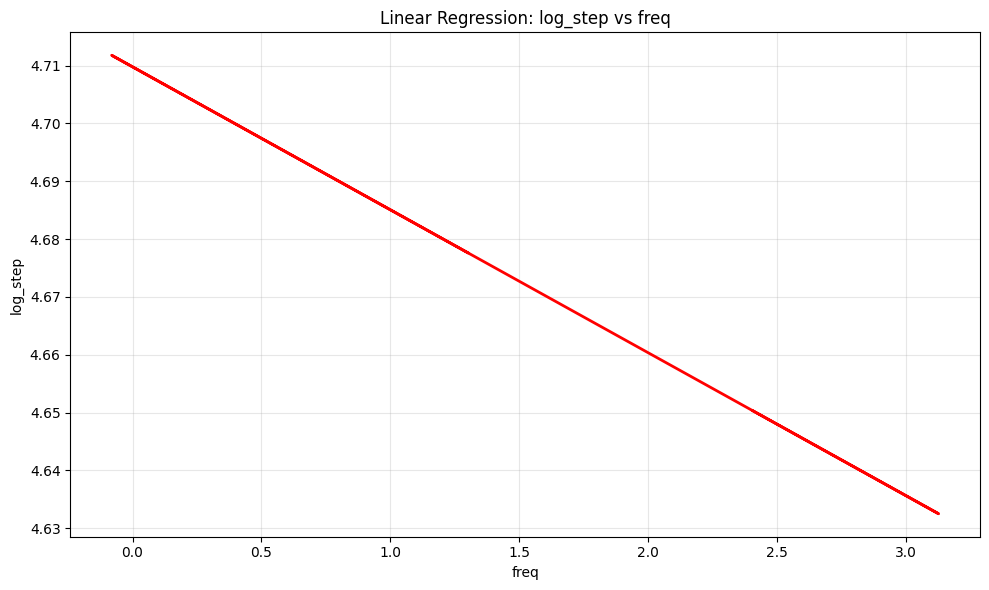

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

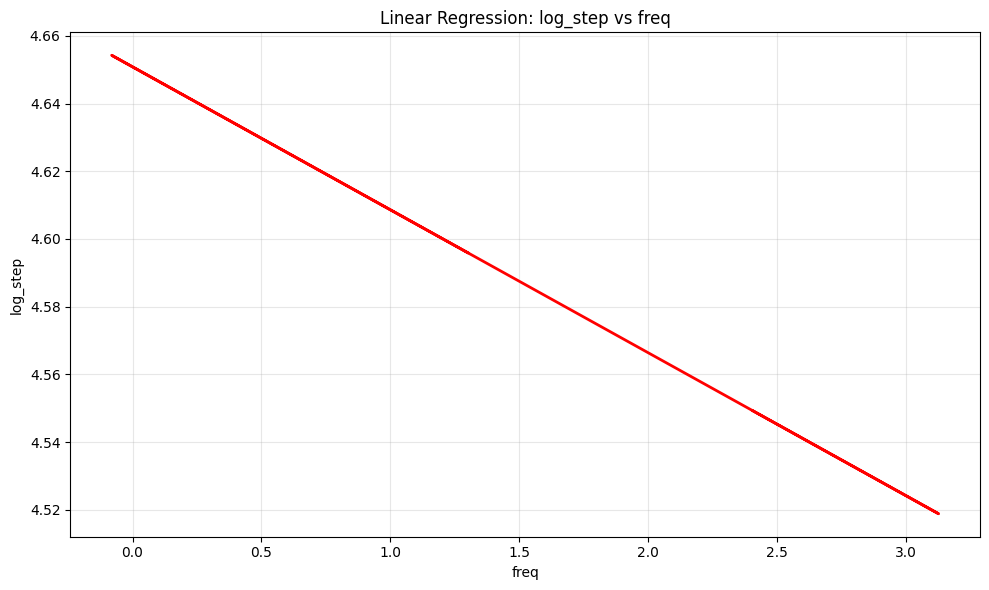

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

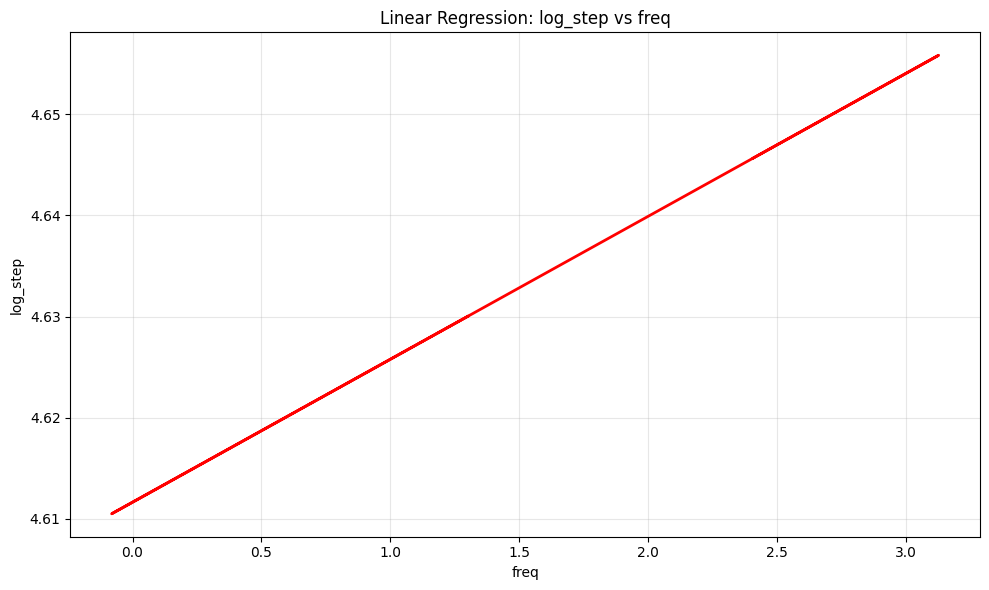

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

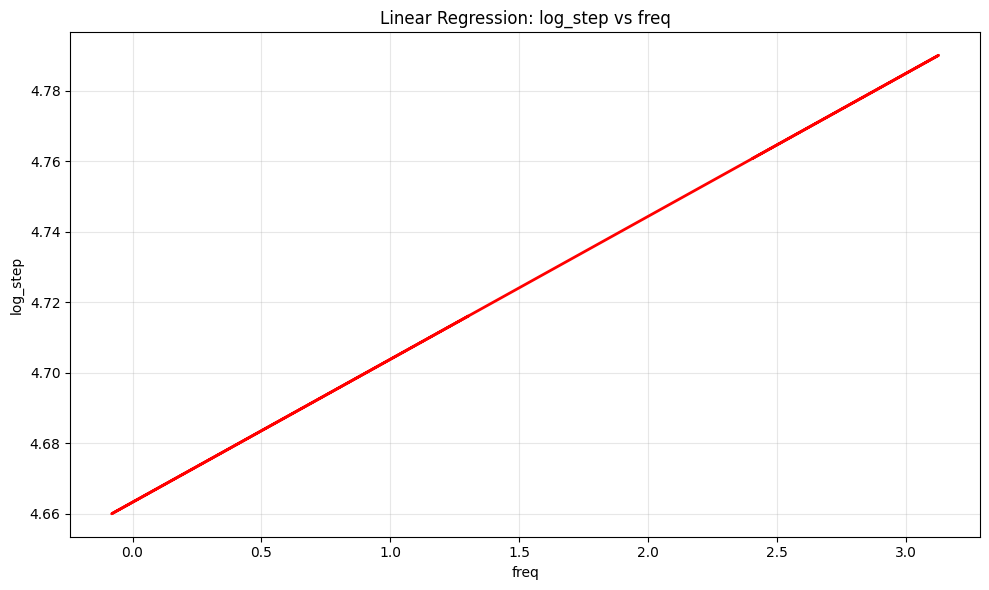

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

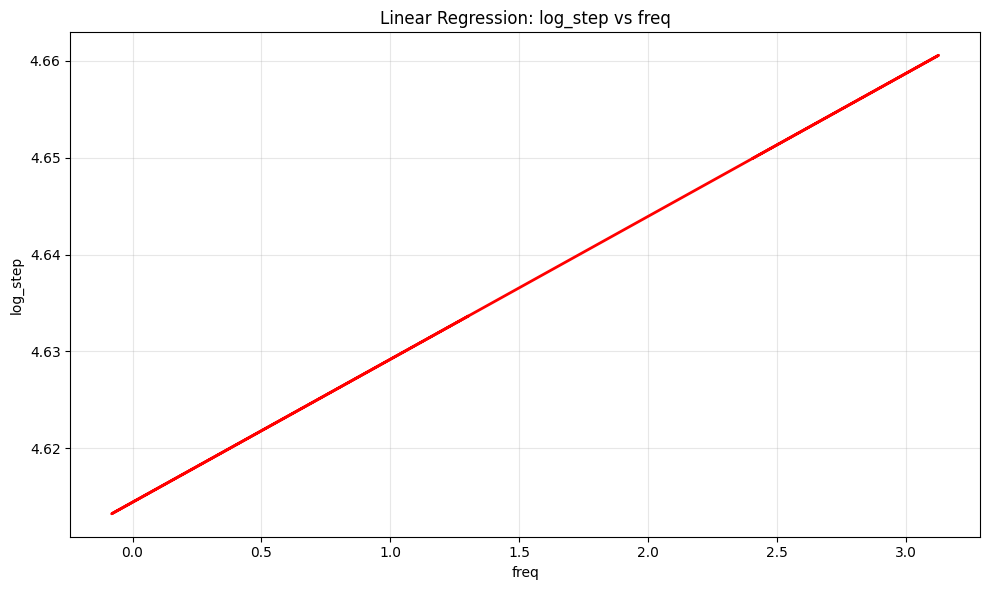

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

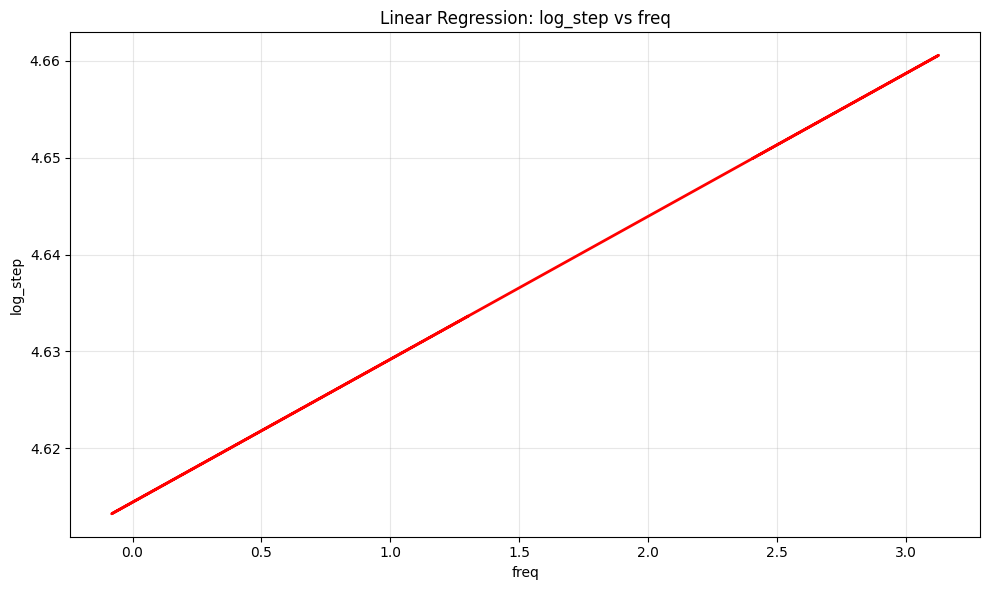

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

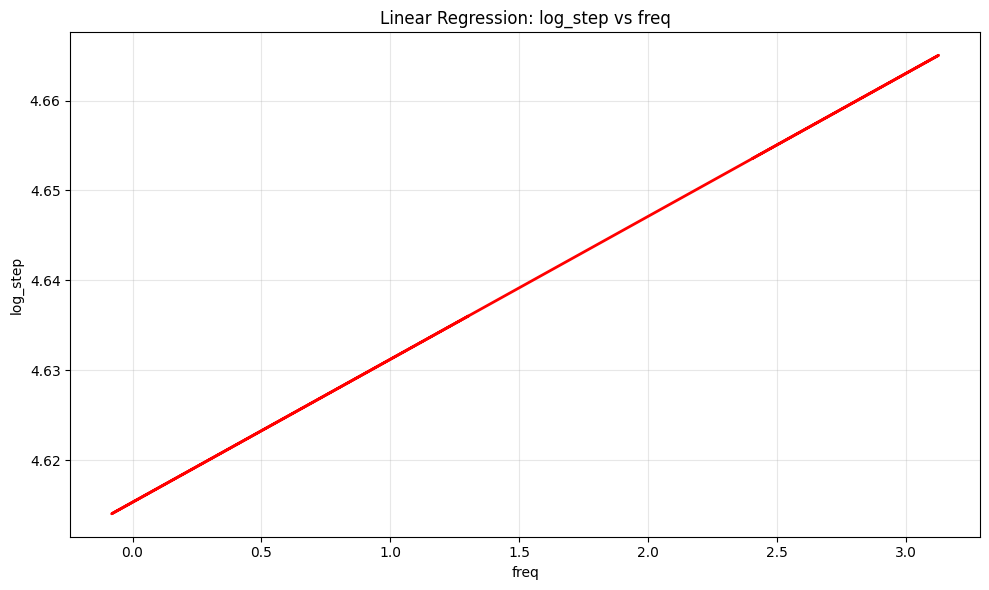

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

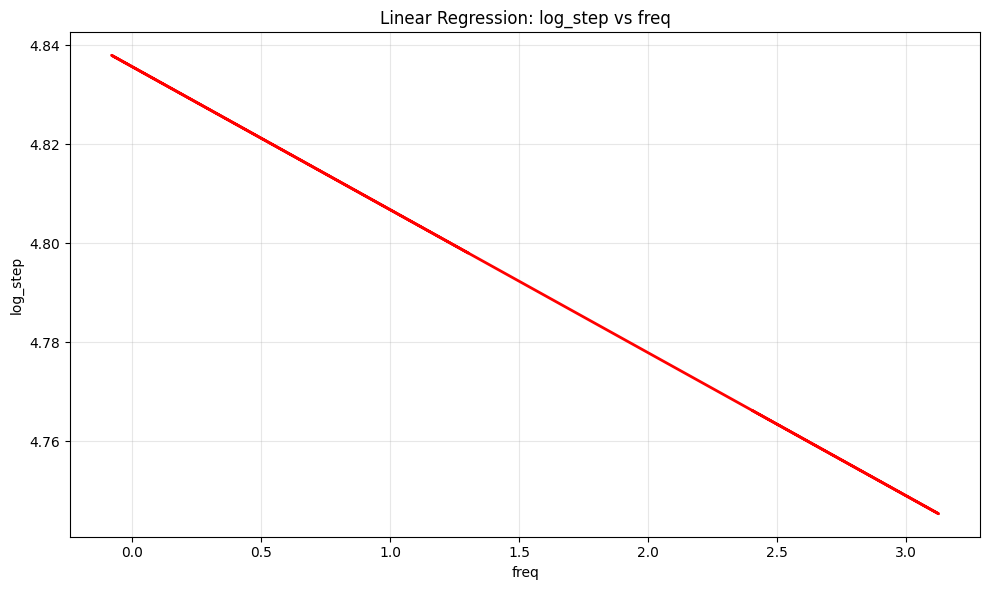

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

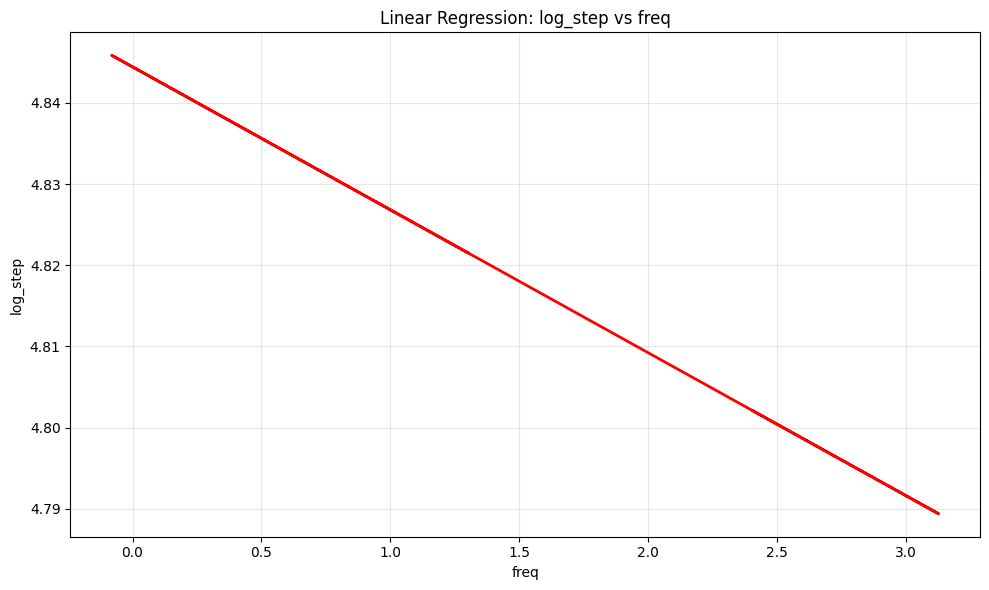

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

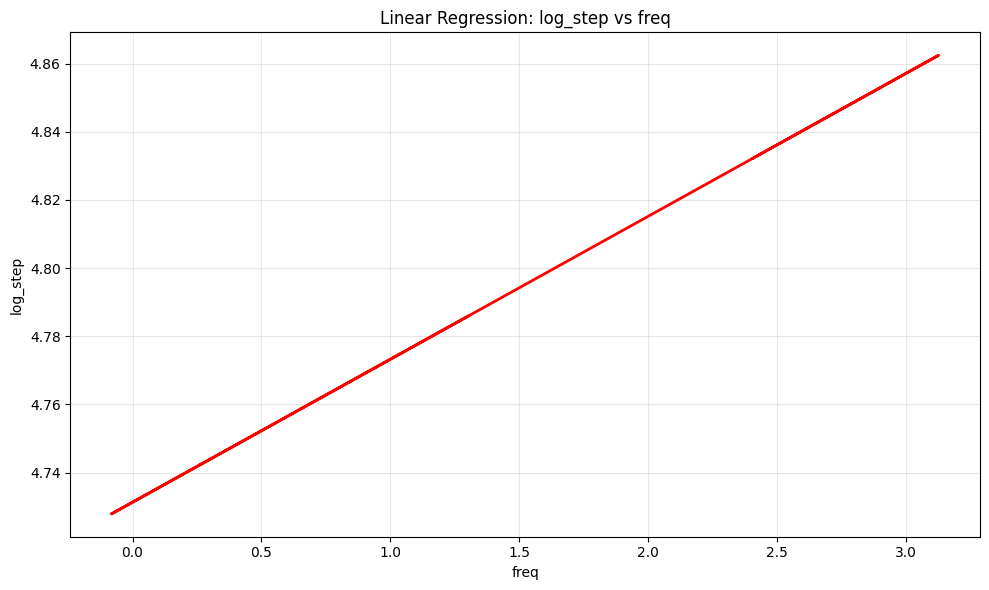

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

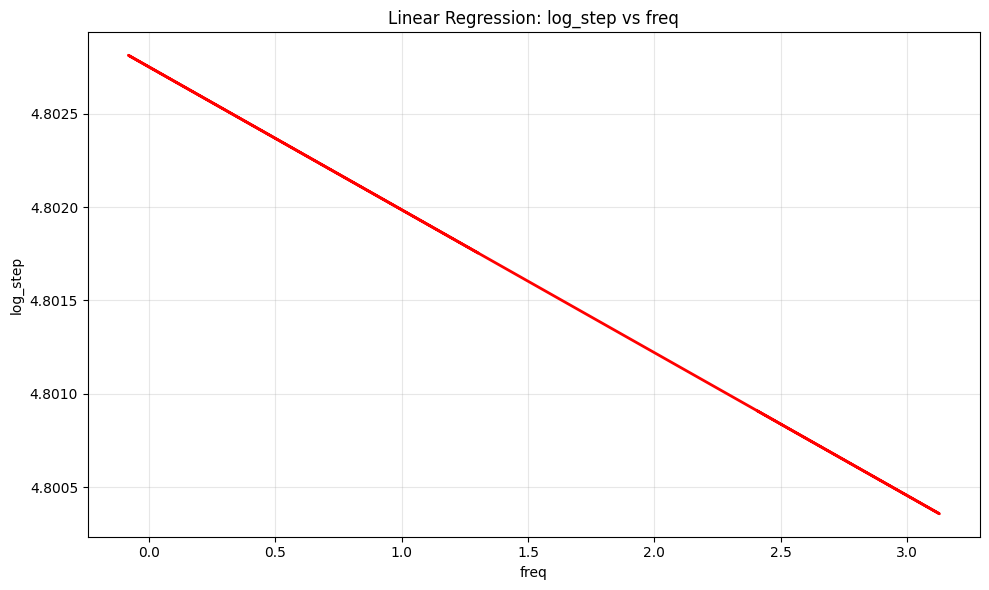

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

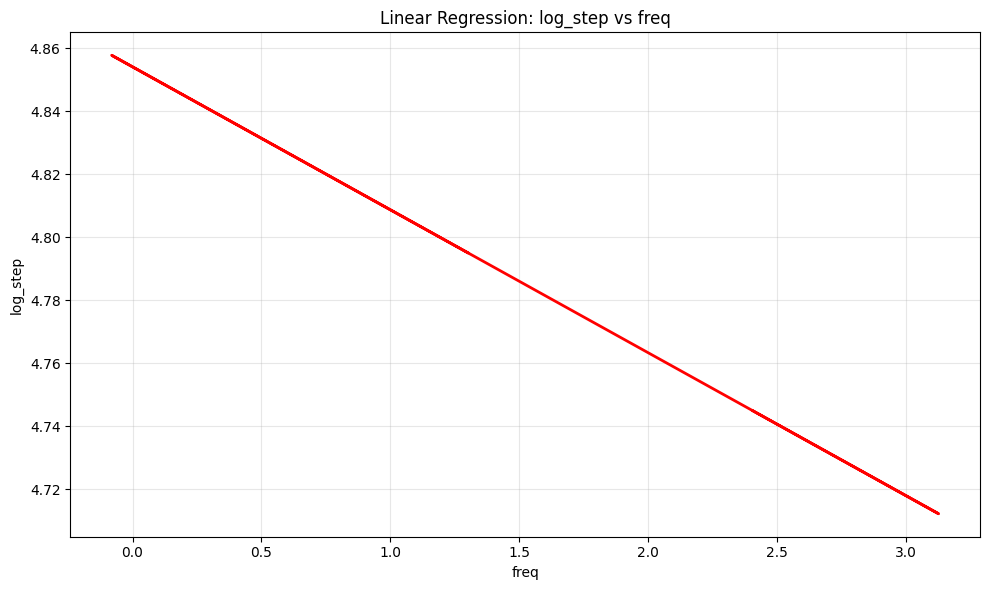

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

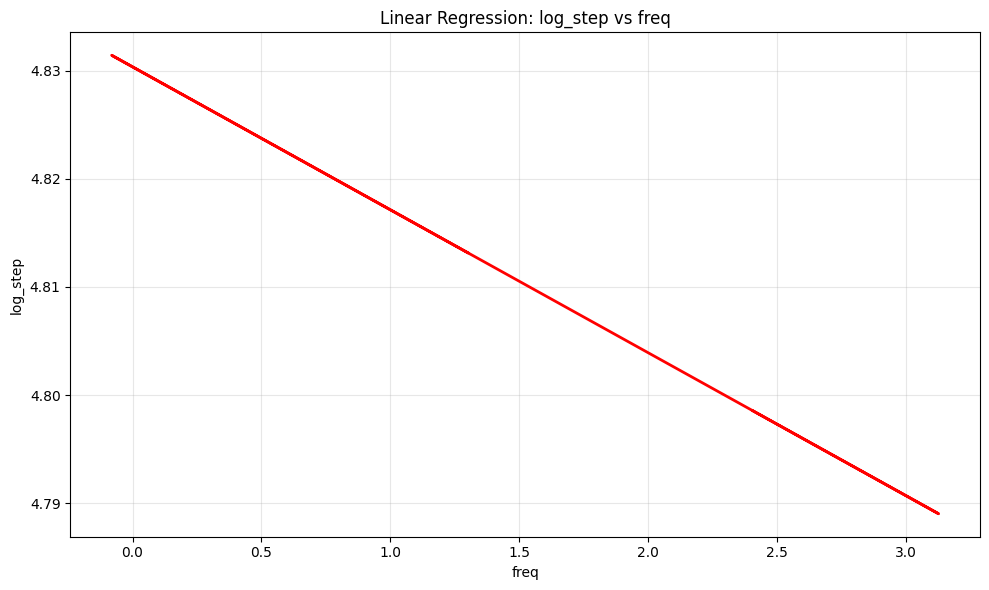

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

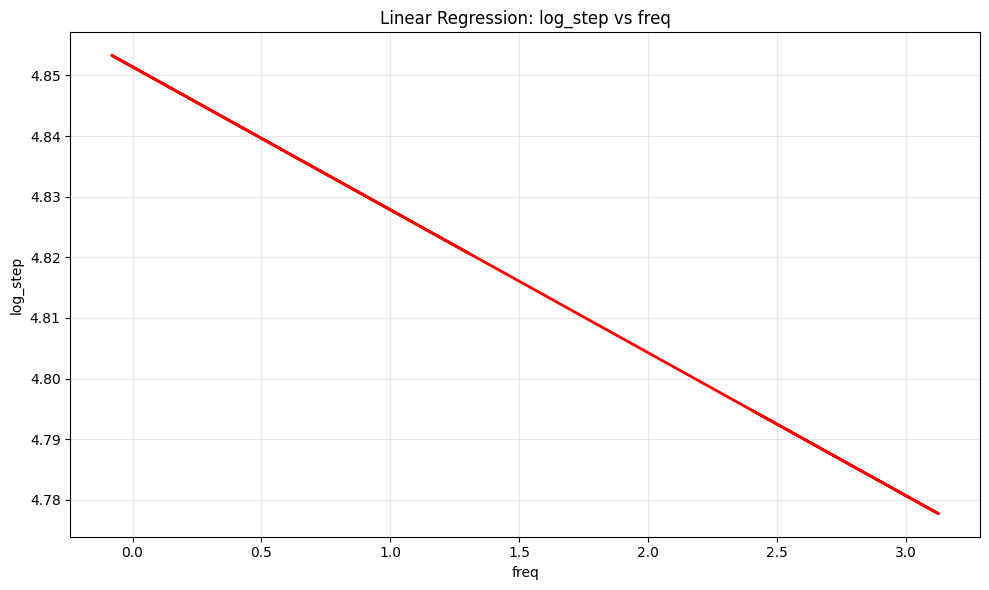

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

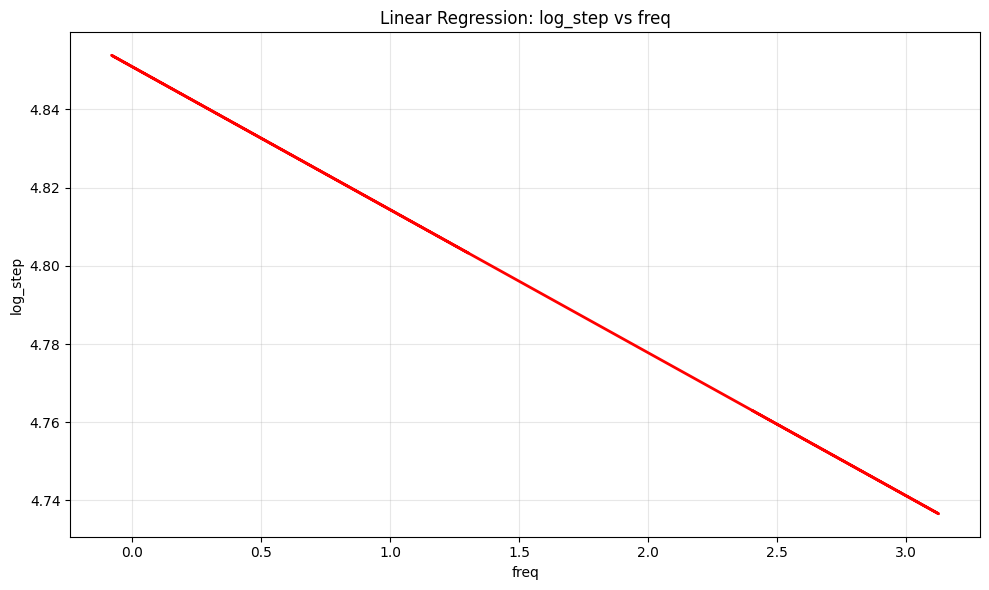

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

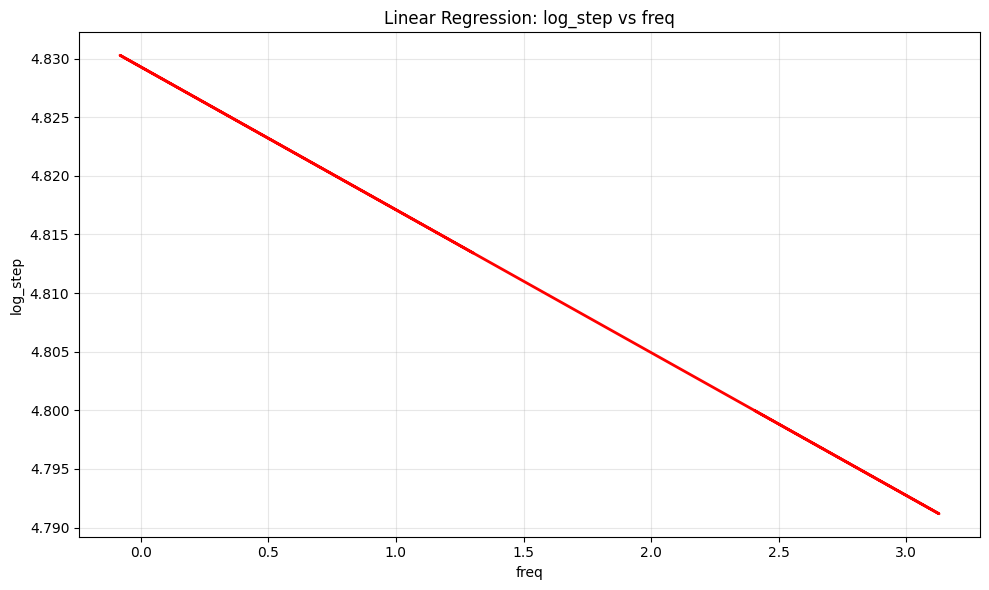

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

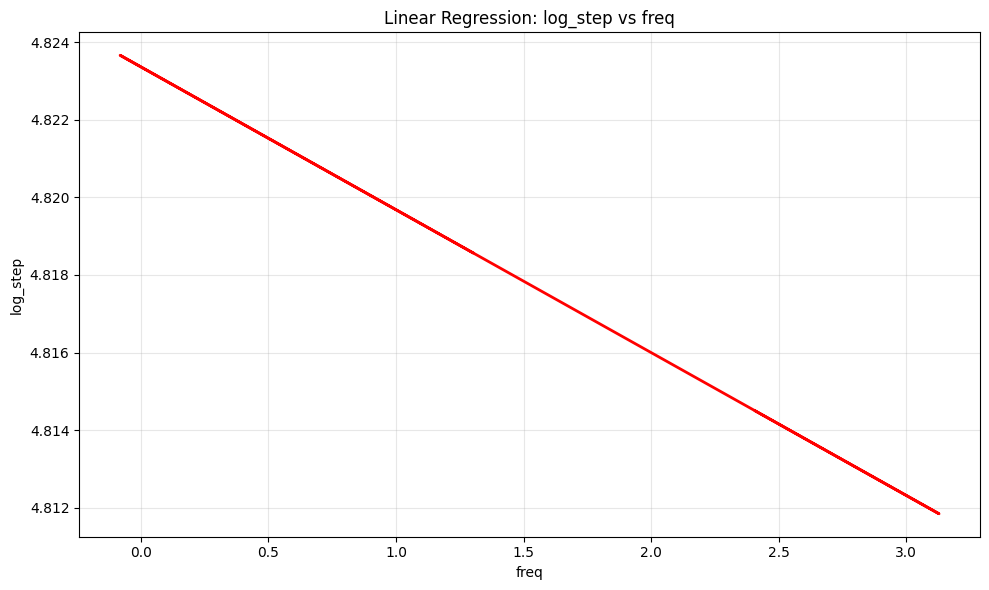

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

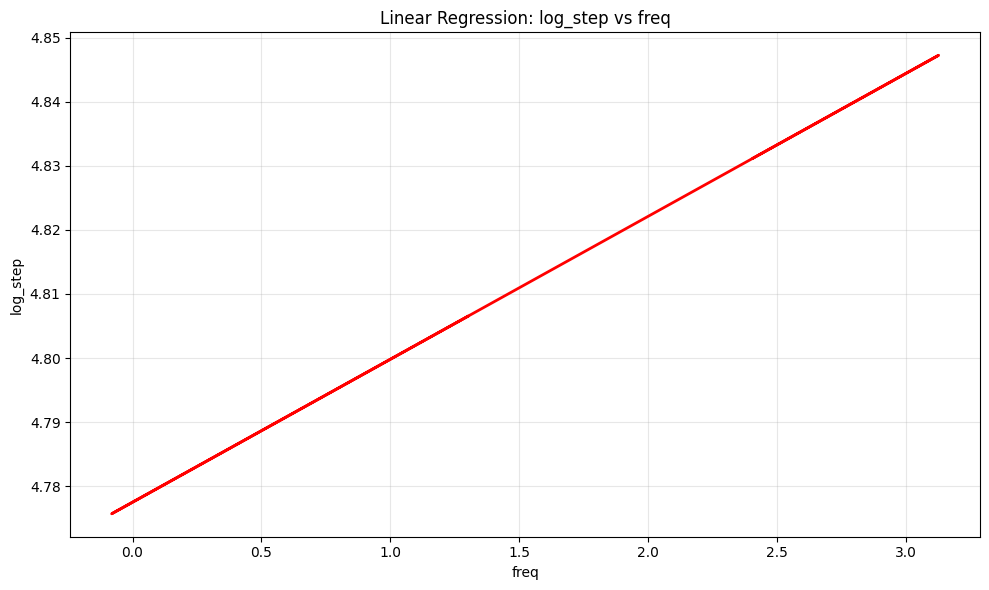

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

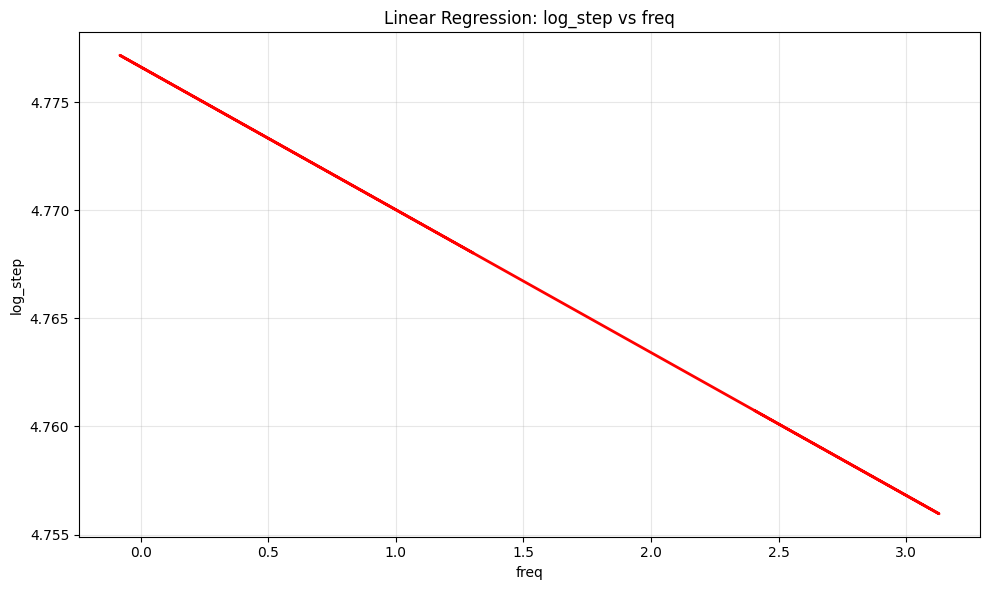

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

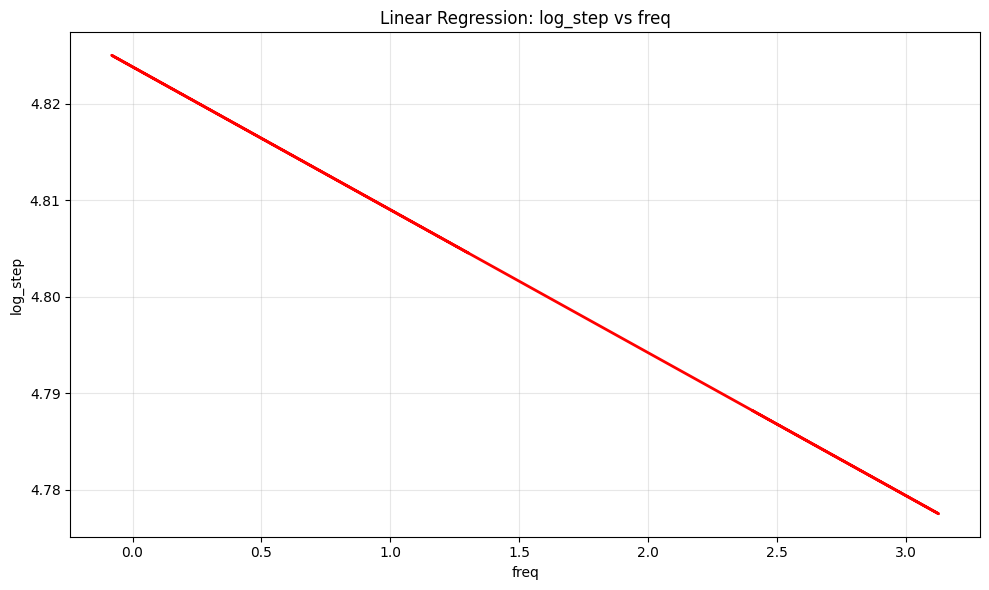

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

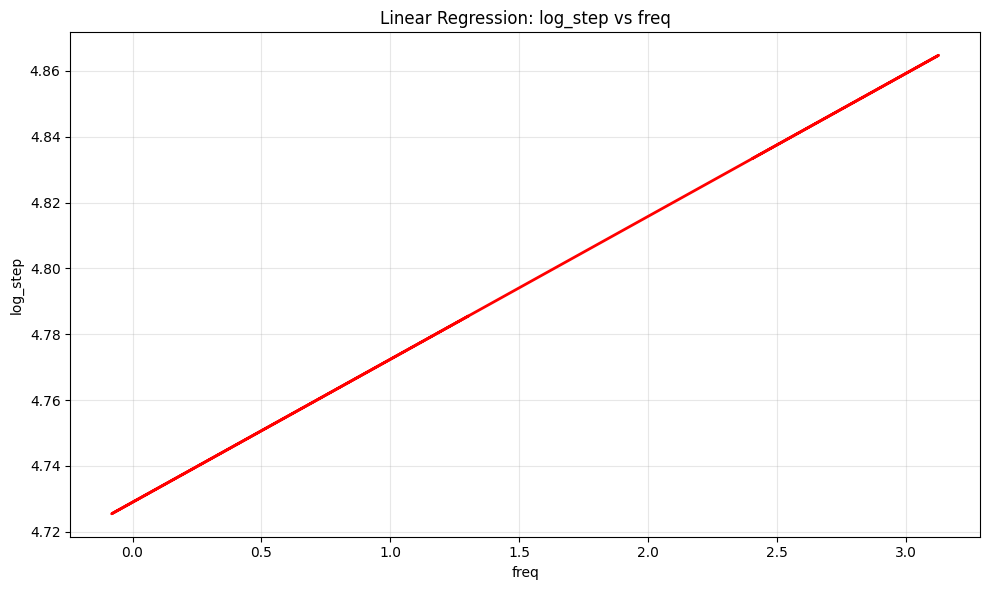

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

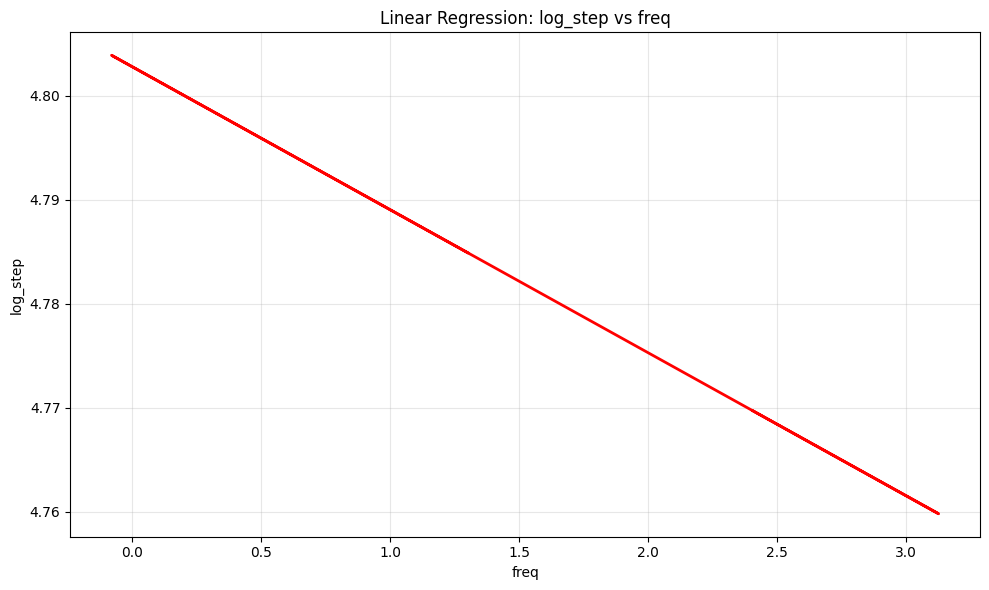

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

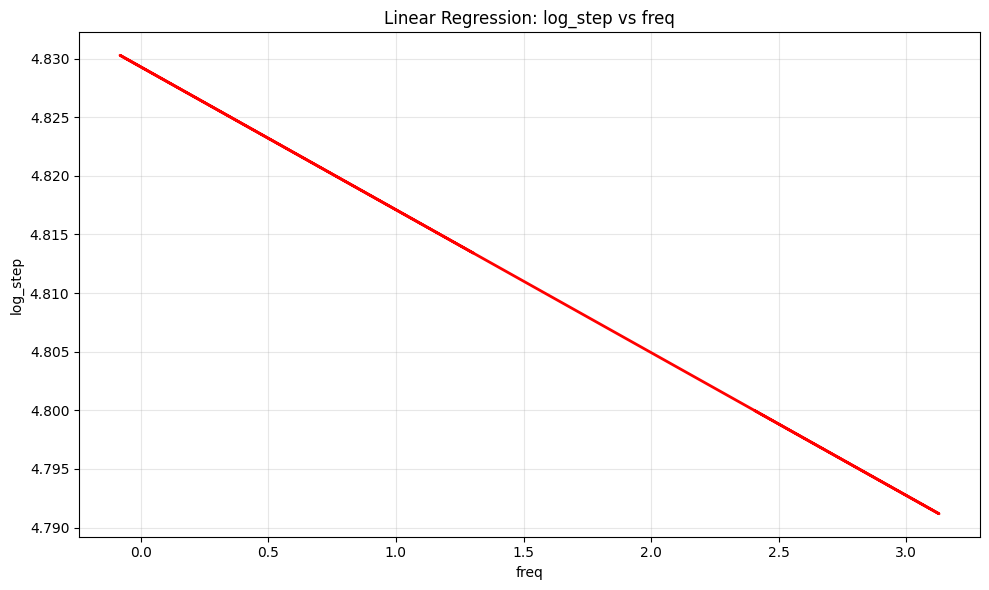

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

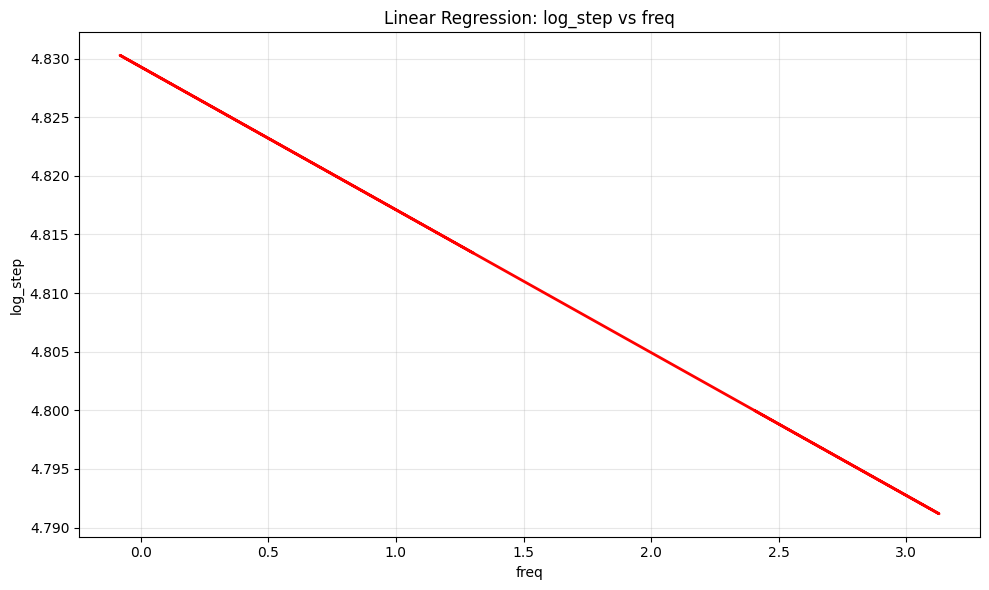

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_11427/810432476.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

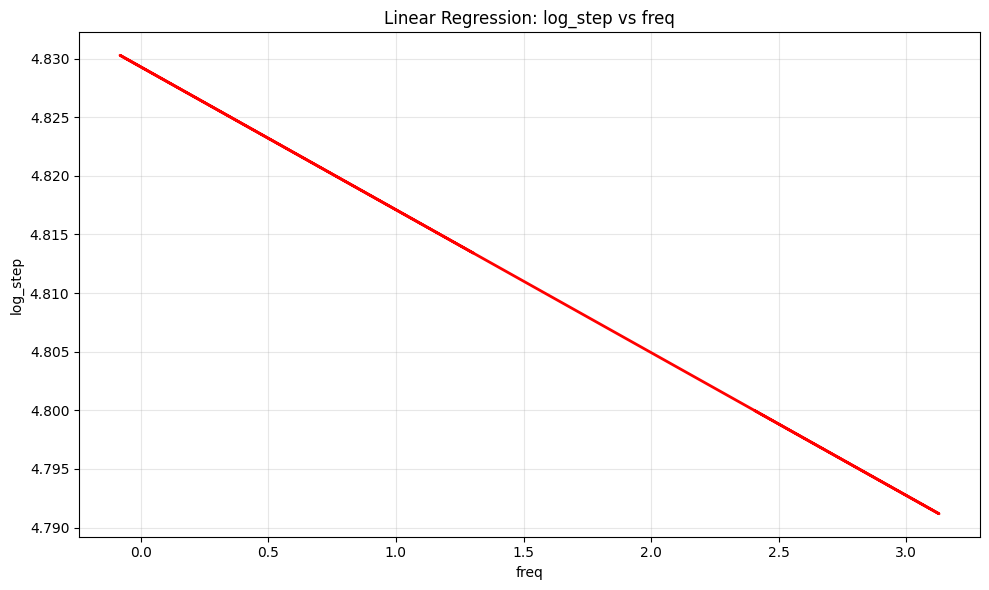

In [180]:

eval_set = "merged"
ablation_lst = ["mean","zero","random"]

model_lst = ["70m","410m"]
neuron_lst = [10,50,500]
vec_lst = ["mean","longtail"]

freq_path = Path("/Users/jliu/workspace/RAG/datasets/freq/EleutherAI/pythia-410m")
merged = load_freq(freq_path)

# loop ablation conditions
for model in model_lst:
    for vec in vec_lst:
        for ablation in ablation_lst:
            for neuron in neuron_lst:
                file_path = surprisal_path/vec/ablation/eval_set/"EleutherAI"/f"pythia-{model}-deduped_{neuron}.csv"
                #header_dict = {"vec":vec,"neuron":neuron,"model":model, "ablation":ablation,"eval":eval_set}
                fit_curves(file_path,merged)


In [23]:
output_dir = fig_path / "longtail/mean_dev"

csv_path = surprisal_path/"stat_longtail.csv"
stat_frame.to_csv(csv_path)
# Create bar plots
plot_ablation_development(csv_path = csv_path, output_dir=output_dir)

Loaded data with 11180 rows


KeyError: 'model'

In [20]:
stat_frame

target_word     3.6021     3.6990     3.7782     3.8451     3.9031  \
0        selves   5.081853   5.416893   4.124481   5.220534   4.862697   
1        selves  17.644665  18.861048  17.559488  17.878273  18.469198   
2        selves  14.928635  12.061435  10.565018  10.374101  10.940964   
3          mega  16.311314  15.832009  14.677512  14.177814  14.877748   
4          mega   4.480710   5.664289   6.455317   5.371166   4.632257   
..          ...        ...        ...        ...        ...        ...   
855  sequential  10.008779   9.910406  10.689094   9.528986   9.869879   
856  sequential  15.780682  17.437595  16.608139  16.090855  16.860809   
857  sequential  17.249266  16.266680  15.876972  16.683195  16.257427   
858  sequential  15.896375  18.271229  17.637014  18.538010  18.623041   
859  sequential  14.345398  13.888851  13.880960  14.220003  14.885036   

        3.9542     4.0000     4.0414     4.0792  ...     5.1271     5.1303  \
0     5.096181   6.417839   5.226209   5.769827  ...   6.213547   5.314106   
1    18.526283  19.255491  19.397448  17.376797  ...  17.518230  18.387201   
2     9.913749   9.732368   8.407385   7.128606  ...   8.868980  11.017687   
3    14.358662  15.187715  15.574939  15.028000  ...  18.276966  17.798519   
4     5.908920   4.709406   7.789823   8.462381  ...   7.428173   7.502834   
..         ...        ...        ...        ...  ...        ...        ...   
855  10.767529  11.541224  11.122530  11.857928  ...  15.398462  14.143032   
856  17.975807  18.003193  18.846928  18.393614  ...  20.725424  20.061646   
857  16.662134  16.476358  17.618317  16.301893  ...  16.725649  17.505480   
858  20.010315  20.857876  20.662243  21.248787  ...  15.501699  15.824737   
859  13.928383  12.838572  14.282108  14.650572  ...  13.588174  13.329967   

        5.1335     5.1367     5.1399     5.1430     5.1461     5.1492  \
0     6.148089   6.114464   5.198809   4.443929   4.843375   4.924430   
1    18.358990  17.008142  16.828926  16.810110  16.976974  16.668314   
2     9.682637   8.860136   9.185990   9.024972   8.837464   8.731384   
3    16.199627  17.646471  17.193914  17.553915  16.560934  17.113174   
4     7.651610   7.297141   7.253968   7.484074   5.976861   6.791261   
..         ...        ...        ...        ...        ...        ...   
855  13.438570  15.183613  15.002991  14.454885  15.818866  15.862360   
856  18.153223  17.644268  18.790319  18.355658  17.843464  18.749432   
857  15.737692  16.359528  16.702173  16.037361  15.780669  15.959530   
858  13.800708  13.727693  15.833467  14.081892  13.531441  14.575825   
859  13.146820  11.974399  13.506434  13.412413  12.503687  10.828233   

        5.1523     5.1553  
0     5.555794   6.092495  
1    17.255592  15.695961  
2     8.797934   7.254818  
3    17.571278  15.673454  
4     7.664072   7.568632  
..         ...        ...  
855  16.185511  14.513931  
856  19.737968  19.517014  
857  16.519619  14.738835  
858  14.708428  14.567089  
859  14.427569  12.302189  

[11180 rows x 141 columns]

In [19]:
output_dir = fig_path / "freq_dev"
csv_path = surprisal_path/"stat.csv"
# Create bar plots
plot_ablation_freq(csv_path = csv_path, output_dir=output_dir)

Loaded data with 4060 rows
Processing model=70m, ablation=mean
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=70m, ablation=zero
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=70m, ablation=random
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=410m, ablation=mean
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=410m, ablation=zero
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing mod

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Finished loading base file


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_26706/3418708400.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(surprisal_path / neuron_mode / word_set / model_family / model_size)


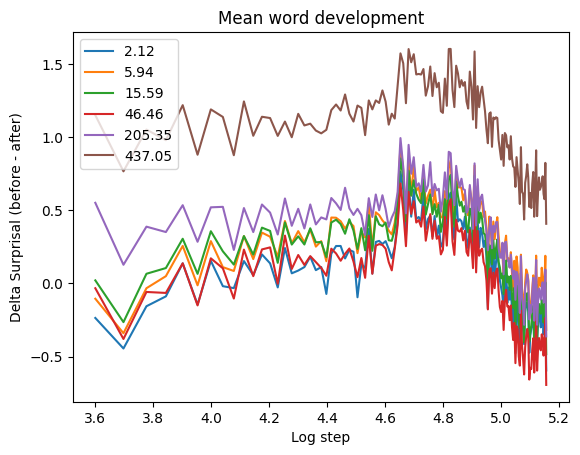

In [41]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-410m-deduped"
data_base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_base_dict = group_word(data_base,group_data,stat_df)
print("Finished loading base file")

data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

Finished loading base file


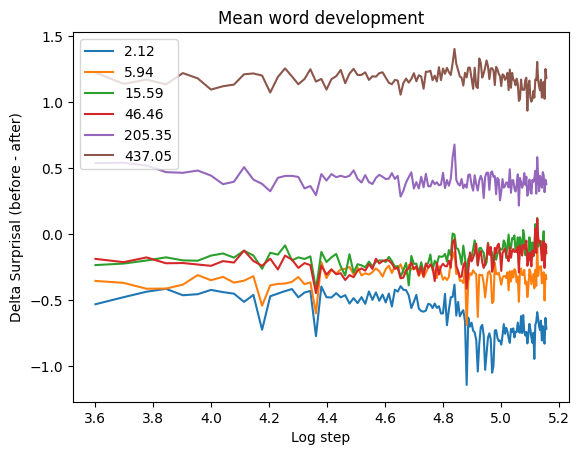

In [37]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-70m-deduped"
data_base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_base_dict = group_word(data_base,group_data,stat_df)

print("Finished loading base file")

data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

Finished loading base file


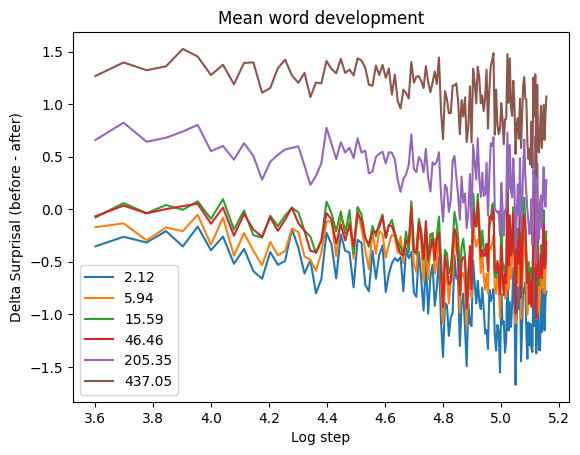

In [39]:
data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_500.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

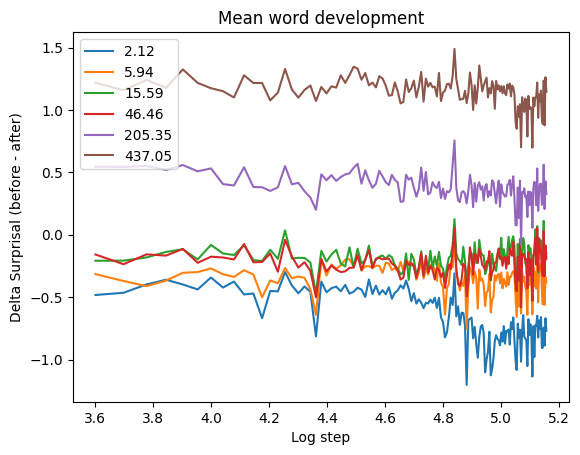

In [40]:
data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_100.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

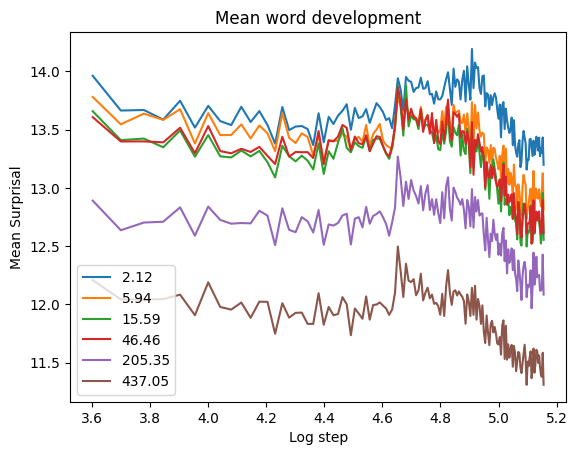

In [7]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-70m-deduped"
data = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_dict = group_word(data,group_data,stat_df)
df = compare_neuron_mean(data_dict)

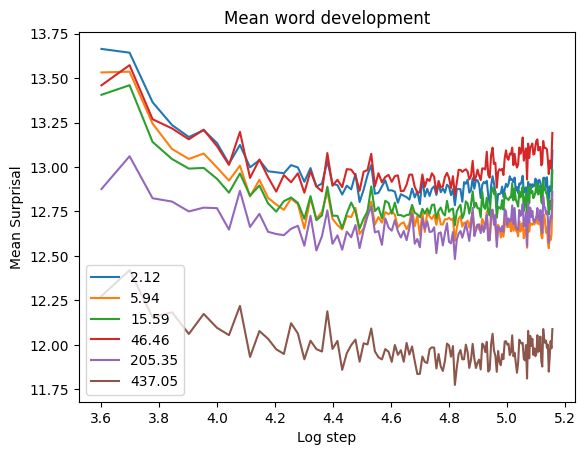

In [8]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-410m-deduped"
data = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_dict = group_word(data,group_data,stat_df)
df = compare_neuron_mean(data_dict)

In [28]:
df

log_step  surprisal
0    3.602060  12.274673
1    3.698970  12.420142
2    3.778151  12.155556
3    3.845098  12.183611
4    3.903090  12.061696
..        ...        ...
135  5.143015  11.849906
136  5.146128  11.929979
137  5.149219  12.021145
138  5.152288  11.981333
139  5.155336  12.089322

[140 rows x 2 columns]